# Returns Playback

We will be using the z-score as a leading indicator for when to take small caps exposure on. 

# Packages

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read Data

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(os.path.join(parent_path, "data"))
df_path = os.path.join(os.path.join(data_path, "dm_prices.parquet"))

df_raw = pd.read_parquet(path = df_path, engine = "pyarrow")

# Calculate Returns Differential

In [3]:
tickers = ["RSP", "SPY"]

df_spread = (df_raw.query(
    "variable_0 == 'Adj Close' & variable_1 == @tickers").
    drop(columns = ["variable_0"]).
    rename(columns = {"variable_1": "ticker"}).
    pivot(index = "Date", columns = "ticker", values = "value").
    pct_change(periods = 3 * 30).
    dropna().
    assign(
        spread_diff = lambda x: x.SPY - x.RSP,
        z_score = lambda x: (x.spread_diff - x.spread_diff.rolling(window = 30 * 3).mean()) / x.spread_diff.rolling(window = 30 * 3).std())
    [["spread_diff", "z_score"]])

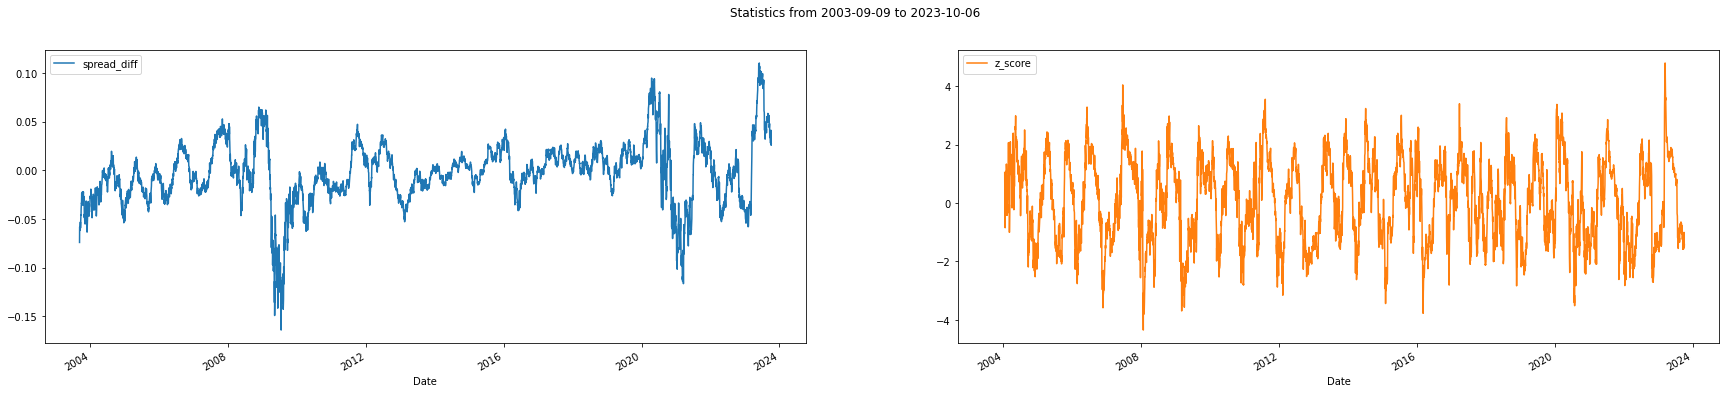

In [4]:
df_spread.plot(
    subplots = True, layout = (1, 2),
    figsize = (30,6),
    title = "Statistics from {} to {}".format(
        df_spread.index.min().date(),
        df_spread.index.max().date()))

plt.show()

# Using fixed z-score value

We will loop through each year and if the z-score gets above 2.6 we'll use that as the starting point for the year. Then with that starting point we'll see what the returns are for the next 6 months

In [5]:
df_year = (df_spread[
    ["z_score"]].
    reset_index().
    assign(year = lambda x: x.Date.dt.year.astype(int)).
    dropna())

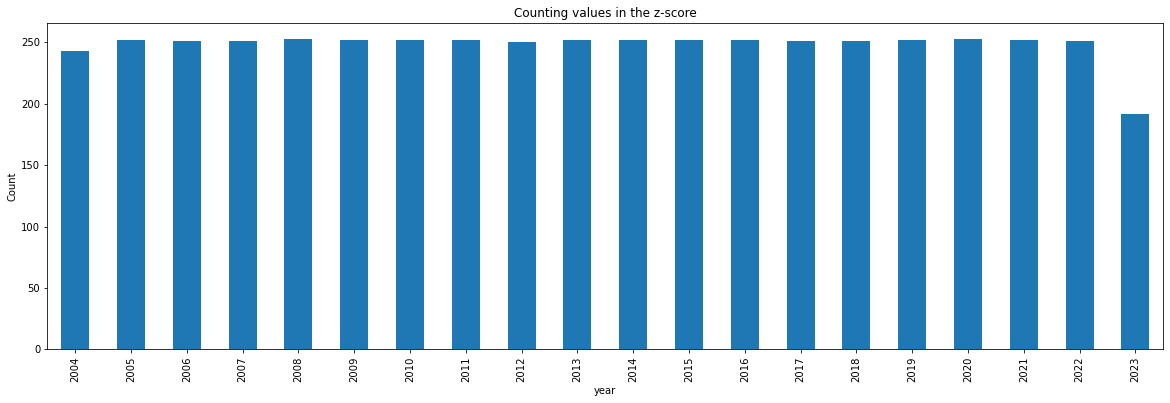

In [6]:
(df_year.drop(
    columns = ["Date"]).
    groupby("year").
    agg("count").
    plot(
        kind = "bar", figsize = (20,6),
        legend = False,
        ylabel = "Count",
        title = "Counting values in the z-score"))

plt.show()

In [7]:
def _find_z_score_val(
    df: pd.DataFrame,
    z_score_value: float) -> pd.DataFrame:
    
    return(df.sort_values(
        "Date").
        query("z_score >= @z_score_value").
        head(1))

In [8]:
df_start = (df_year.groupby(
    "year").
    apply(_find_z_score_val, 2.6))

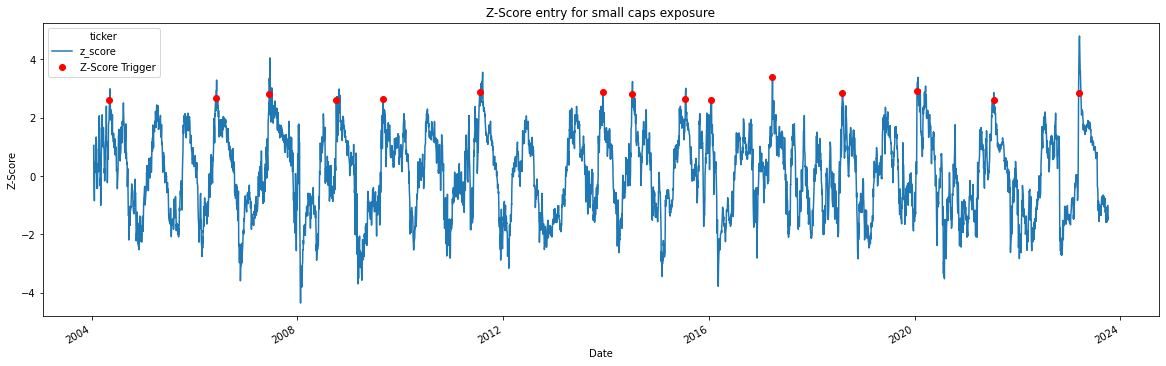

In [9]:
fig, axes = plt.subplots(figsize = (20,6))

(df_spread[
    ["z_score"]].
    dropna().
    plot(
        ax = axes))

(df_start[
    ["Date", "z_score"]].
    rename(columns = {
        "z_score": "Z-Score Trigger"}).
    set_index("Date").
    plot(
        ax = axes,
        marker = "o",
        linestyle = "None",
        color = "red",
        ylabel = "Z-Score",
        title = "Z-Score entry for small caps exposure"))

plt.show()

## Looking at 3 month ahead returns

In [10]:
russ_tickers = ["IWM", "IWV", "IWB"]

df_russ = (df_raw.query(
    "variable_0 == 'Adj Close' & variable_1 == @russ_tickers").
    drop(columns = ["variable_0"]).
    dropna().
    rename(columns = {"variable_1": "ticker"}).
    pivot(index = "Date", columns = "ticker", values = "value").
    pct_change().
    dropna().
    reset_index().
    melt(id_vars = "Date"))

In [11]:
df_trade = (df_start.assign(
    trade_regime = ["trade{}".format(i + 1) for i in range(len(df_start))]))

In [12]:
df_combined = (df_russ.merge(
    right = df_trade, how = "left", on = ["Date"]).
    fillna(method = "ffill").
    dropna())

In [13]:
def _get_holding_period(
    df: pd.DataFrame,
    holding_period = 30 * 3) -> pd.DataFrame:
    
    return(df.query(
        "Date != Date.min()"). # lags signal for one day
        tail(holding_period).
        assign(cum_rtn = lambda x: np.cumprod(1 + x.value) - 1)) 

In [14]:
df_trade_rtn = (df_combined.groupby(
    ["ticker", "trade_regime"]).
    apply(_get_holding_period).
    reset_index(drop = True))

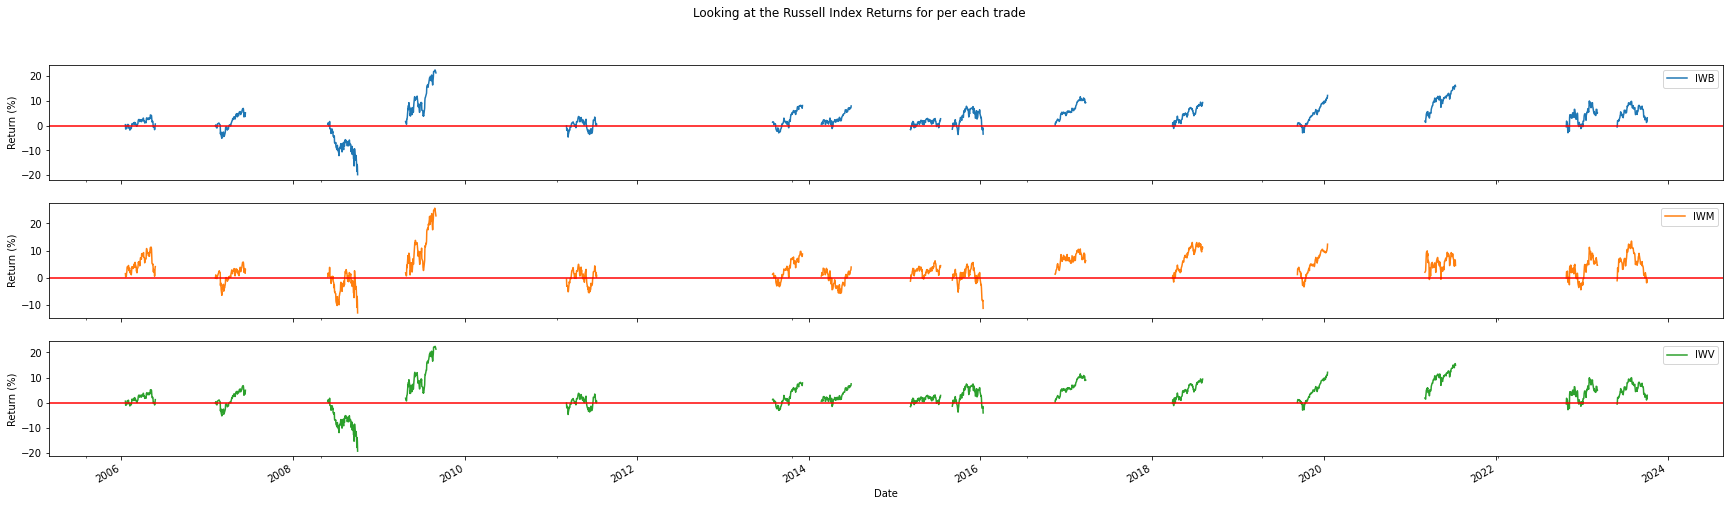

In [15]:
(df_trade_rtn[
    ["Date", "ticker", "cum_rtn"]].
    merge(right = df_russ, how = "outer", on = ["Date", "ticker"]).
    drop(columns = ["value"]).
    assign(cum_rtn = lambda x: x.cum_rtn * 100).
    pivot(index = "Date", columns = "ticker", values = "cum_rtn").
    plot(
        subplots = True, layout = (3,1), figsize = (30,8),
        ylabel = "Return (%)",
        title = "Looking at the Russell Index Returns for per each trade"))

for ax in plt.gcf().axes:
    ax.axhline(y = 0, color = "r")

In [16]:
def _get_index(df: pd.DataFrame) -> pd.DataFrame:
    return(df.sort_values(
        "Date").
        assign(new_index = [i + 1 for i in range(len(df))]))

In [17]:
df_trade_reindex = (df_trade_rtn.groupby(
    ["ticker", "trade_regime"]).
    apply(_get_index).
    assign(cum_rtn = lambda x: x.cum_rtn * 100).
    rename(columns = {"value": "rtn"}))

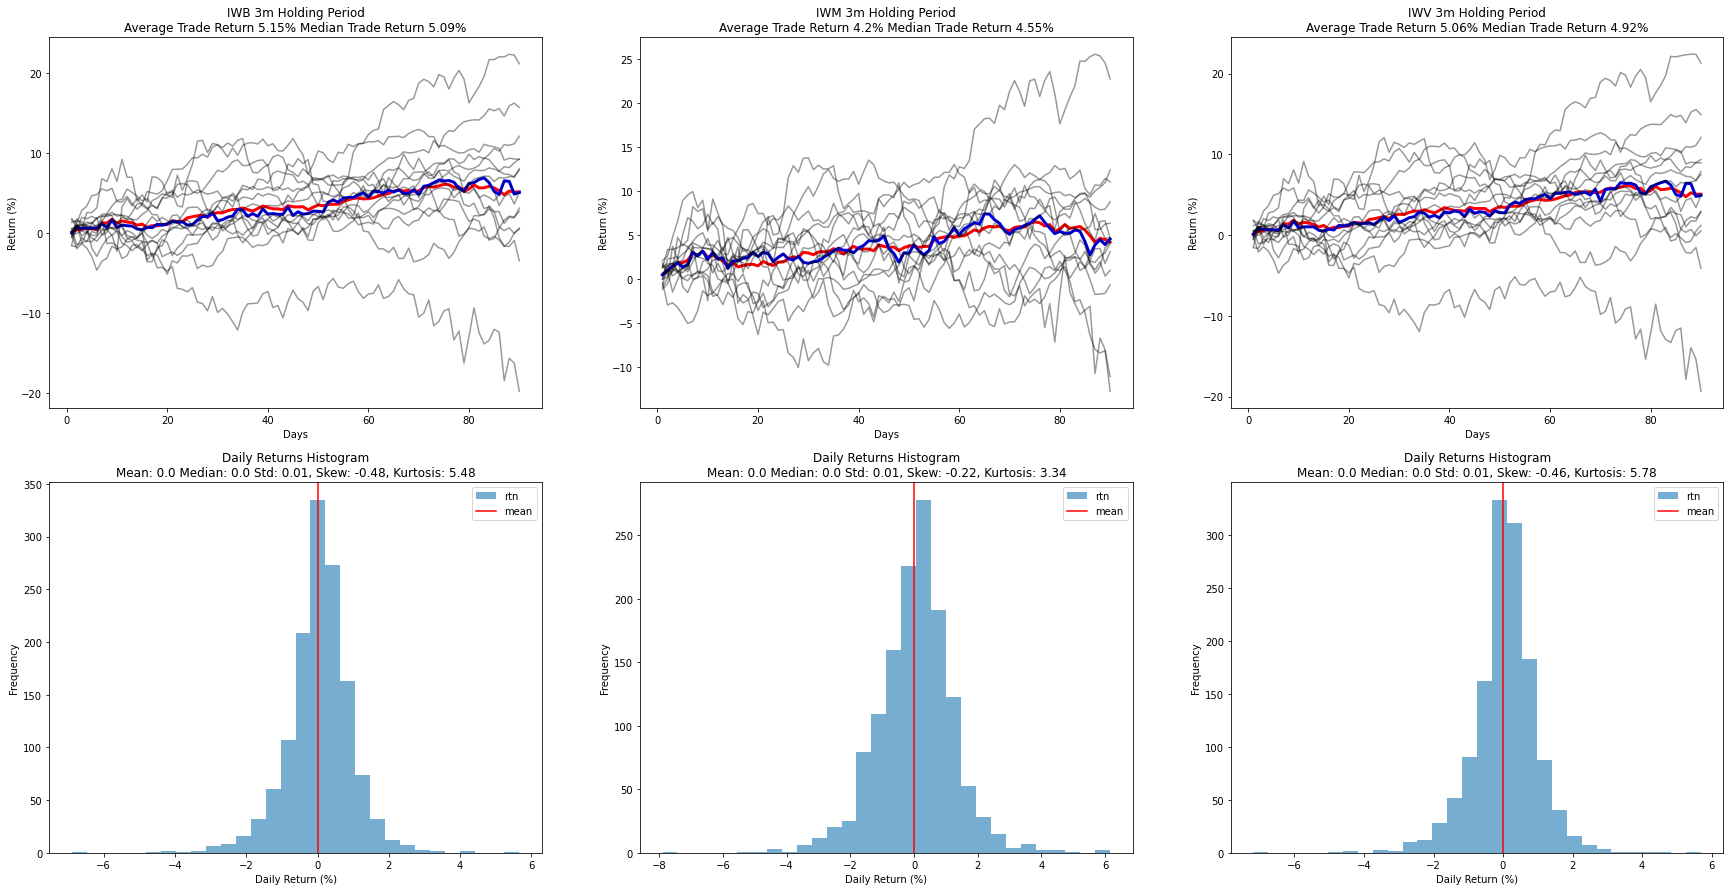

In [18]:
tickers = df_trade_reindex.ticker.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(tickers), nrows = 2, figsize = (len(tickers) * 10, 15))

for i, ticker in enumerate(tickers):
    
    df_tmp = (df_trade_reindex.query(
        "ticker == @ticker")
        [["trade_regime", "cum_rtn", "new_index", "rtn"]])
              
    df_wider = (df_tmp.
        drop(columns = ["rtn"]).
        pivot(index = "new_index", columns = "trade_regime", values = "cum_rtn").
        sort_index())
    
    df_mean, df_median = df_wider.mean(axis = 1), df_wider.median(axis = 1)
    
    (df_mean.plot(
        ax = axes[0,i],
        color = "r",
        linewidth = 3))
    
    (df_median.plot(
        ax = axes[0,i],
        color = "b",
        linewidth = 3))

    df_wider.plot(
        ax = axes[0,i],
        legend = False,
        color = "black",
        ylabel = "Return (%)",
        alpha = 0.4,
        title = "{} 3m Holding Period\nAverage Trade Return {}% Median Trade Return {}%".format(
            ticker,
            round(df_mean.tail(1).iloc[0], 2),
            round(df_median.tail(1).iloc[0], 2)))
    
    mean, median, skew, kurtosis, std = df_tmp["rtn"].mean(), df_tmp["rtn"].median(), df_tmp["rtn"].skew(), df_tmp["rtn"].kurtosis(), df_tmp["rtn"].std()
    
    (df_tmp
        [["rtn"]].
        assign(rtn = lambda x: x.rtn * 100).
        plot(
            kind = "hist",
            ax = axes[1,i],
            bins = 30,
            alpha = 0.6,
            title = "Daily Returns Histogram\nMean: {} Median: {} Std: {}, Skew: {}, Kurtosis: {}".format(
                round(mean,2),
                round(median,2),
                round(std,2),
                round(skew,2),
                round(kurtosis,2))))
    
    axes[1,i].axvline(x = mean, label = "mean", color = "r")
    axes[1,i].legend()
    
    axes[0,i].set_xlabel("Days")
    axes[1,i].set_xlabel("Daily Return (%)")

# Z-Score Sign as an entry

In this case we'll use z-score sign as an entry method into the trade. In this case we'll sell our position if the z-score goes negative. 

In [34]:
df_signal = (df_spread.assign(
    sign = lambda x: np.sign(x.z_score)).
    query("sign == 1")
    [["sign"]].
    reset_index())

In [62]:
cum_rtn = (np.cumprod(df_russ.merge(
    right = df_signal, how = "inner", on = "Date").
    drop(columns = ["sign"]).
    pivot(index = "Date", columns = "ticker", values = "value") 
    + 1) - 1) * 100

<AxesSubplot:xlabel='Date'>

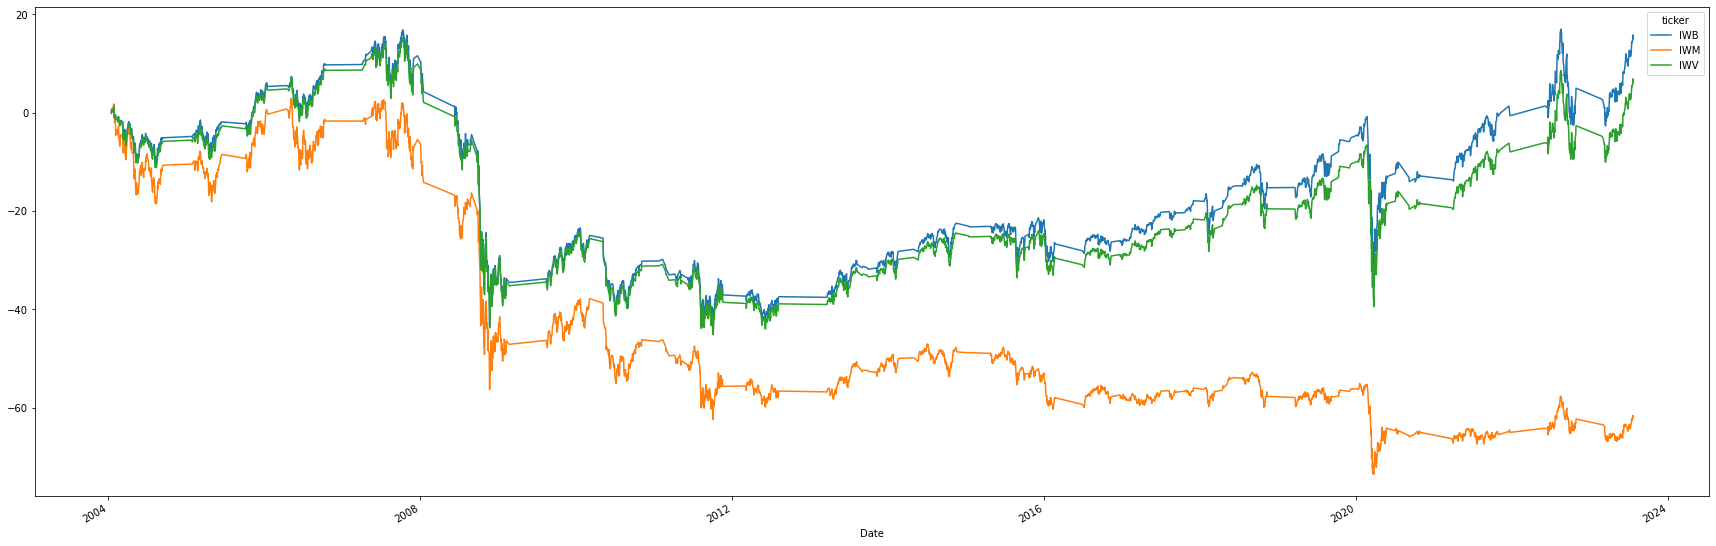

In [63]:
(cum_rtn.plot(
    layout = (1,3),
    figsize = (30,10)))